In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
from datetime import datetime
import argparse
import json
import os
import sys
from typing import DefaultDict, List

sys.path.append(".")
sys.path.append("./hf_transformers")

from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import T5ForConditionalGeneration
from transformers import T5Tokenizer
from transformers import set_seed
import numpy as np
import torch

from data_reader import DataPoint, GetDataAsPython, MinimalDataPoint
from prepare_data import create_data_tbug
from prepare_data import create_dataset
from prepare_data import extract_warning_types
from prepare_data import filter_rule
from utils import boolean_string
from utils import get_scores_weighted_average
from utils import get_current_time
import os


In [3]:
set_seed(42)

In [4]:
import socket
local = False if 'computecanada' in socket.gethostname() else True

In [5]:
if local:
    storage_directory = './storage/'
else:
    storage_directory = '/scratch/arminz/'

In [6]:
model_name = 't5-small' # args.model_name
result_dir = '' #args.result_dir
repo = None #args.repo
design = 'repo-based-included' #args.design
error_type = '' #args.error_type
load_model = f'{storage_directory}/training-tbug/t5-small_repo-based_29-04-2022_09-38-17/checkpoint-14235' #args.load_model
batch_size = 16 #args.batch_size
eval_acc_steps = 1 # eval-acc-steps

In [7]:
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
# Create job's directory
if result_dir != "":
    test_result_directory = args.result_dir
else:
    if not repo:
        test_result_directory = f'{storage_directory}/testing-tbug/{now.day}/general_{model_name}_test_{design}_{dt_string}'
    else:
        test_result_directory = f'{storage_directory}/testing-tbug/{now.day}/per-repo/{model_name}_test_{repo.rsplit("/", 1)[1][-20:]}_{dt_string}'


In [8]:
data = GetDataAsPython(f"{storage_directory}/data_and_models/data/data_autofix_tracking_repo_specific_final.json")
data_eslint = GetDataAsPython(f"{storage_directory}/data_and_models/data/data_autofix_tracking_eslint_final.json")
data += data_eslint

In [9]:
all_warning_types = extract_warning_types(data)
if error_type != "":
    all_warning_types = [error_type]

In [10]:
(train_inputs, train_labels, test_inputs, test_labels, train_info, test_info, ) =\
    create_data_tbug(data, all_warning_types, include_warning=True, design=design, select_repo=repo, back_translation=True)

splitting by : repo-based-included
train size: 52
test size: 3374


In [11]:
# Load the tokenizer and the model that will be tested.
tokenizer = T5Tokenizer.from_pretrained(f'{load_model}')
print("Loaded tokenizer from directory {}".format(f'{load_model}'))
model = T5ForConditionalGeneration.from_pretrained(f'{load_model}')
print("Loaded model from directory {}".format(f'{load_model}'))
print(f"cuda:{torch.cuda.current_device()}")
model.to(f"cuda:{torch.cuda.current_device()}")
model.resize_token_embeddings(len(tokenizer))
model.eval()

Loaded tokenizer from directory ./storage//training-tbug/t5-small_repo-based_29-04-2022_09-38-17/checkpoint-14235
Loaded model from directory ./storage//training-tbug/t5-small_repo-based_29-04-2022_09-38-17/checkpoint-14235
cuda:0


T5ForConditionalGeneration(
  (shared): Embedding(32104, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32104, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Dro

In [12]:
train_dataset = create_dataset(
    train_labels['no-invalid-this'], train_inputs['no-invalid-this'], tokenizer, pad_truncate=True, max_length=128
)
# val_dataset = create_dataset(val_labels, val_inputs, tokenizer, pad_truncate=True)

/home/armin/TFix/env/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5.py:185: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


In [13]:
test_inputs['no-invalid-this'][0]

"fix no-invalid-this Unexpected 'this'. \treturn Math.min(0, this.imageHeight - this.scaledRotatedInternalImageHeight);\n:\nexport default function() {\n\treturn Math.min(0, this.imageHeight - this.scaledRotatedInternalImageHeight);\n}\n </s>"

In [14]:
test_labels['no-invalid-this'][0]

"bug no-invalid-this Unexpected 'this'. export default function() {\n\treturn Math.min(0, this.scaledRotatedInternalImageHeightDifference);\n}\n </s>"

In [15]:
training_args = Seq2SeqTrainingArguments(
    output_dir=test_result_directory,
    num_train_epochs=0,
    per_device_eval_batch_size=batch_size,
    logging_dir=test_result_directory,
    logging_steps=100,
    do_eval=True,
    evaluation_strategy="epoch",
    eval_accumulation_steps=eval_acc_steps,  # set this lower, if testing or validation crashes
    predict_with_generate=True,  # never set this to false, it is for testing.
    seed=42,  # default value
)

In [16]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
#     eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

In [17]:
counter = 0
for key in train_inputs:
    counter += len(train_inputs[key])
print("Number of training samples: ", counter)

Number of training samples:  101430


In [18]:
for warning in test_inputs:
    inputs = train_inputs[warning] #test_inputs[warning]
    infos = train_info[warning] #test_info[warning]
    for i, code in enumerate(inputs):
        assert code == infos[i].GetT5Representation(True)[0], "something wrong! stop it!"


In [19]:
da_repos = '/data/all/data/qooxdoo/qooxdoo','/data/all/data/elastic/kibana','/data/all/data/emberjs/ember.js','/data/all/data/zloirock/core-js','/data/all/data/Encapsule-Annex/onm','/data/all/data/sequelize/sequelize','/data/all/data/dcos/dcos-ui','/data/all/data/LivelyKernel/LivelyKernel','/data/all/data/svgdotjs/svg.js','/data/all/data/foam-framework/foam'

In [20]:
# Generate predictions
scores: DefaultDict[str, float] = defaultdict(float)
counts: DefaultDict[str, float] = defaultdict(int)
for i, warning in enumerate(all_warning_types):
    test_warning = [] #test_inputs[warning]
    test_warning_labels = [] #test_labels[warning]
    test_warning_info = [] #train_info[warning] #test_info[warning]
    
    for input_, label_, info_ in zip(train_inputs[warning], train_labels[warning], train_info[warning]):
        if info_.repo not in da_repos:
            continue
        test_warning.append(input_)
        test_warning_labels.append(label_)
        test_warning_info.append(info_)
        
    target_max_length = 256  # Set this to 256 if enough memory
    if not test_warning_labels:
        scores[warning] = 'NA'
        counts[warning] = 0
        continue
    # print(f"rule {i}: {warning}, # {len(test_warning)}")
    test_warning_dataset = create_dataset(
        test_warning_labels,
        test_warning,
        tokenizer,
        pad_truncate=True,
        max_length=target_max_length,
    )

    target_ids = tokenizer(
        test_warning,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=target_max_length,
    ).input_ids
    target_ids = np.array(target_ids)

    output_ids = trainer.predict(
        test_dataset=test_warning_dataset, num_beams=5, max_length=target_max_length
    ).predictions
    output_ids = np.pad(
        output_ids, ((0, 0), (0, target_max_length - output_ids.shape[1])), mode="constant"
    )
    output_ids = np.delete(output_ids, 0, axis=1)
    output_ids = np.insert(output_ids, target_max_length - 1, 0, axis=1)

    correct_counter = np.sum(np.all(np.equal(target_ids, output_ids), axis=1))
    total_counter = len(output_ids)
    for k, output_id in enumerate(output_ids):
        pred = tokenizer.decode(output_id, skip_special_tokens=True)
        predictions = []
        predictions.append(pred)
        test_warning_info[k].predictions = predictions

    scores[warning] = correct_counter / total_counter
    counts[warning] = total_counter
    test_info[warning] = test_warning_info
    print(f"rule {i} ({warning}) acc: {correct_counter / total_counter:.2f}, {total_counter}")

rule 0 (no-invalid-this) acc: 0.02, 161
rule 1 (no-throw-literal) acc: 0.91, 174
rule 2 (no-new-wrappers) acc: 0.33, 3
rule 3 (guard-for-in) acc: 0.15, 20
rule 5 (comma-style) acc: 0.22, 308
rule 6 (prefer-spread) acc: 0.66, 86
rule 7 (no-caller) acc: 0.05, 19
rule 8 (no-extra-bind) acc: 0.00, 2
rule 9 (no-array-constructor) acc: 0.00, 1
rule 10 (prefer-rest-params) acc: 0.62, 155
rule 13 (no-extend-native) acc: 0.42, 24
rule 14 (no-undef) acc: 0.03, 129
rule 15 (no-useless-escape) acc: 0.00, 11
rule 16 (no-dupe-keys) acc: 0.26, 34
rule 17 (no-console) acc: 0.17, 12
rule 18 (no-constant-condition) acc: 0.00, 12
rule 19 (no-duplicate-case) acc: 0.50, 2
rule 20 (no-empty) acc: 0.55, 11
rule 21 (no-extra-semi) acc: 0.75, 244
rule 22 (no-redeclare) acc: 0.29, 45
rule 23 (no-cond-assign) acc: 0.30, 10
rule 24 (no-extra-boolean-cast) acc: 0.55, 20
rule 26 (no-unreachable) acc: 0.28, 18
rule 27 (valid-typeof) acc: 0.00, 1
rule 28 (no-unsafe-finally) acc: 0.00, 1
rule 29 (no-unused-vars) acc: 

In [21]:
with open(f'{storage_directory}/bt_data/scores.json', 'w') as f:
    json.dump(scores, f)

(array([38.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

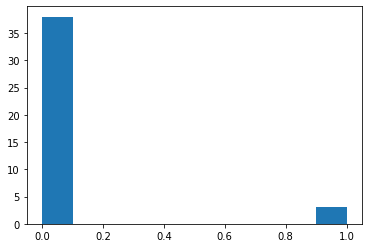

In [22]:
import matplotlib.pyplot as plt
plt.hist([int(x) for x in scores.values() if x != 'NA'])

In [26]:
average, count = get_scores_weighted_average(scores, counts)
number_of_warnings = len([scores[k] for k in scores if scores[k] != 'NA'])

# assert count == counter, 'counts must be equal'

scores["average"] = average
scores['number_of_warnings'] = number_of_warnings
scores['samples_count'] = count

print(f'score average: {average:.2f} samples_count: {scores["samples_count"]}')


score average: 0.41 samples_count: 1710


In [25]:
count, counter

(1710, 101430)

In [27]:
ind = 5

In [28]:
print(test_info['no-throw-literal'][ind].predictions[0])

fix no-throw-literal Expected an object to be thrown. throw "Malformed date format: " + format; : catch (exc) { throw "Malformed date format: " + format; }


In [29]:
print(test_info['no-throw-literal'][ind].GetT5Representation(True)[0])

fix no-throw-literal Expected an object to be thrown.     throw "Malformed date format: " + format;
:
  catch (exc) {
    throw "Malformed date format: " + format;
  }

 </s>


In [30]:
print(test_info['no-throw-literal'][ind].target_code)

  catch (exc) {
    throw new Error("Malformed date format: " + format);
  }




In [31]:
repos = defaultdict(int)
for warning in scores:
    for item in test_info[warning]:
        repos[item.repo] += 1

In [32]:
repos = dict(sorted(repos.items(), key=lambda item: item[1], reverse=True))
repos # this must be applied on the train data not the test idiot!

{'/data/all/data/qooxdoo/qooxdoo': 432,
 '/data/all/data/elastic/kibana': 180,
 '/data/all/data/emberjs/ember.js': 171,
 '/data/all/data/zloirock/core-js': 160,
 '/data/all/data/Encapsule-Annex/onm': 155,
 '/data/all/data/sequelize/sequelize': 140,
 '/data/all/data/dcos/dcos-ui': 129,
 '/data/all/data/LivelyKernel/LivelyKernel': 123,
 '/data/all/data/svgdotjs/svg.js': 118,
 '/data/all/data/foam-framework/foam': 102,
 '/data/all/data/ctx-core/ctx-core': 8,
 '/data/all/data/duojs/duo': 6,
 '/data/all/data/GoogleChrome/lighthouse': 4,
 '/data/all/data/tlrobinson/streampunk.js': 4,
 '/data/all/data/patrickjquinn/P-Brain.ai': 3,
 '/data/all/data/coreyp1/defiant': 3,
 '/data/all/data/applitopia/immutable-sorted': 3,
 '/data/all/data/SuperMap/iClient-JavaScript': 2,
 '/data/all/data/open-webrtc-toolkit/owt-client-javascript': 2,
 '/data/all/data/basicdays/co-pg': 2,
 '/data/all/data/eggjs/egg-view-nunjucks': 2,
 '/data/all/data/nypublicradio/ember-hifi': 2,
 '/data/all/data/andreasasprou/reac

In [ ]:
# repo = '/data/all/data/qooxdoo/qooxdoo'
# repo

In [ ]:
data_points = []
for repo, cnt in sorted(repos.items(), key=lambda item: item[1], reverse=True)[:10]:
#     print(repo)
    for warning in scores:
        for item in test_info[warning]:
            if item.repo == repo:
                data_points.append(MinimalDataPoint(item.predictions, item.target_code, item.repo))
                
    new_dir = f'{storage_directory}/bt_data/{repo}.json'
    print(new_dir)
    os.makedirs(new_dir[:new_dir.rfind('/')],exist_ok=True)
    with open(new_dir, "w", errors="ignore") as f:
        json.dump([m.__dict__ for m in data_points], f)

In [ ]:
# import os
# new_dir = f'{storage_directory}/bt_data/{repo}.json'
# os.makedirs(new_dir[:new_dir.rfind('/')],exist_ok=True)
# with open(new_dir, "w+", errors="ignore") as f:
#     json.dump([m.__dict__ for m in data_points], f)

In [ ]:
new_dir